# Create an anndata object from the GEO files

The GEO files were not readable by R on the time this document was started.

Therefore this Pything based import script has been added here.

In [1]:
import scvelo as scv
import loompy
import scanpy
#import scanpy.api
import igraph
import phate
import glob, os
import pandas as pd
import os
import re
import anndata
import subprocess
from collections import Counter
import numpy as np

In [2]:
rawF = "GSE190965_raw.h5ad"
ofile = "GSE190965_analyzed.h5ad"

In [3]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

scvelo==0.2.4
loompy==3.0.6
scanpy==1.8.2
igraph==0.9.9
phate==1.0.7
pandas==1.5.0.dev0+268.gbe8d1ec88
re==2.2.1
anndata==0.8.0
numpy==1.21.6


In [4]:
adata = scanpy.read_mtx( 'GSE190965_spliced.mtx.gz')
adata

AnnData object with n_obs × n_vars = 58197 × 60662

In [5]:
adata.layers['spliced'] = adata.X
adata.layers

Layers with keys: spliced

In [6]:
adata2 = scanpy.read_mtx( 'GSE190965_unspliced.mtx.gz')

In [7]:
adata.layers['unspliced'] = adata2.X
adata

AnnData object with n_obs × n_vars = 58197 × 60662
    layers: 'spliced', 'unspliced'

In [8]:
! zcat GSE190965_features.tsv.gz | head -n 3

ENSG00000223972	DDX11L1
ENSG00000227232	WASH7P
ENSG00000278267	MIR6859-1

gzip: stdout: Broken pipe


In [9]:
ann = pd.read_csv( 'GSE190965_features.tsv.gz' , sep="\t", header=None )
ann

,0,1
0,ENSG00000223972,DDX11L1
1,ENSG00000227232,WASH7P
2,ENSG00000278267,MIR6859-1
3,ENSG00000243485,MIR1302-2HG
4,ENSG00000284332,MIR1302-2
...,...,...
60657,ENSG00000276017,AC007325.1
60658,ENSG00000278817,AC007325.4
60659,ENSG00000277196,AC007325.2
60660,ENSG00000278625,RF00026


In [10]:
ann.columns =['GeneID', 'GeneSymbol' ]
adata.var = ann.set_index('GeneSymbol')

In [11]:
! zcat GSE190965_barcodes.tsv.gz | head -n 3

HS_BM_1_AAACCCAAGACACACG	HS_BM_1
HS_BM_1_AAACCCAAGTGTTGTC	HS_BM_1
HS_BM_1_AAACCCATCCTCTCTT	HS_BM_1

gzip: stdout: Broken pipe


In [12]:
obs = pd.read_csv('GSE190965_barcodes.tsv.gz', sep="\t", header=None)
obs

,0,1
0,HS_BM_1_AAACCCAAGACACACG,HS_BM_1
1,HS_BM_1_AAACCCAAGTGTTGTC,HS_BM_1
2,HS_BM_1_AAACCCATCCTCTCTT,HS_BM_1
3,HS_BM_1_AAACCCATCTCCGAGG,HS_BM_1
4,HS_BM_1_AAACGAATCCACACAA,HS_BM_1
...,...,...
58192,MSC_O2_TTTGTTGGTGACAGCA,MSC_O2
58193,MSC_O2_TTTGTTGGTGCATACT,MSC_O2
58194,MSC_O2_TTTGTTGGTGTTAGCT,MSC_O2
58195,MSC_O2_TTTGTTGTCCACATAG,MSC_O2


In [13]:
obs.columns = ['Barcode', 'sname']
adata.obs = obs.set_index( 'Barcode' )
adata

AnnData object with n_obs × n_vars = 58197 × 60662
    obs: 'sname'
    var: 'GeneID'
    layers: 'spliced', 'unspliced'

In [14]:
adata.write( rawF )
print (rawF )
! ls -lh {rawF}

GSE190965_raw.h5ad
-rw-rw-r-- 1 med-sal med-sal 1.1G Mar  6 10:47 GSE190965_raw.h5ad


In [15]:
regex = re.compile('_[AGCT]*$')
sname = [ regex.sub( '', cellid ) for cellid in adata.obs.index ]
np.unique(sname)

array(['BM_O1', 'BM_O2', 'HS_BM_1', 'HS_BM_2', 'MSC_O1', 'MSC_O2',
       'MSC_Y2', 'MSC_Y3', 'Y1'], dtype='<U7')

In [16]:
adata.obs['sname'] = sname

In [17]:
RP = re.compile('^RP[SL]')
MT = re.compile('^MT')
def test(x):
    r = True
    if RP.match(x) or MT.match(x): 
        r = False
    return (r)

    
OK = [ test(x) for x in adata.var.index ]
freq = Counter(OK)
print(freq)
adata.X.shape

Counter({True: 58854, False: 1808})


(58197, 60662)

In [18]:
adata._inplace_subset_var( np.array(OK) )
adata

AnnData object with n_obs × n_vars = 58197 × 58854
    obs: 'sname'
    var: 'GeneID'
    layers: 'spliced', 'unspliced'

In [19]:
scanpy.pp.filter_cells(adata, min_counts=1000 )

In [20]:
scanpy.pp.downsample_counts(adata, counts_per_cell= 1000 )

In [21]:
scanpy.pp.filter_genes(adata, min_counts=1 )
scv.pp.log1p(adata)
scanpy.pp.highly_variable_genes(adata, n_top_genes=3000)
print ( Counter( adata.var['highly_variable']))
adata

Counter({False: 31994, True: 3003})


AnnData object with n_obs × n_vars = 25067 × 34997
    obs: 'sname', 'n_counts'
    var: 'GeneID', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    layers: 'spliced', 'unspliced'

In [22]:
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
scanpy.tl.umap(adata,n_components=3)
scanpy.tl.louvain(adata)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:15) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:28) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [23]:
adata

AnnData object with n_obs × n_vars = 25067 × 34997
    obs: 'sname', 'n_counts', 'louvain'
    var: 'GeneID', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'louvain'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [24]:
adata.obsm['X_umap_3d'] = adata.obsm['X_umap']
scanpy.tl.umap(adata,n_components=2)

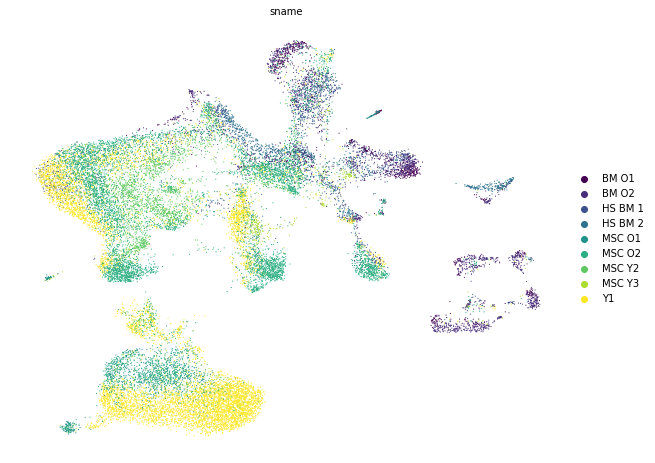

In [25]:
scv.pl.scatter(adata, color='sname', figsize =(10,8), colorbar=True, legend_loc='right margin', palette='viridis')

In [26]:
if os.path.exists(ofile):
    os.remove(ofile)
adata.write(ofile)
print (ofile)

GSE190965_analyzed.h5ad


# And now also load the clusters from the publication

In [28]:
clusters = pd.read_csv('../data/Hongzhe_clustering_and_2dUMAP_louvain11_merged_95_renamed.csv')
clusters

,Unnamed: 0,louvain11_merged.95_renamed,umap2d_X,umap2d_Y
0,HS_BM_1_AAACCCAAGACACACG,31,8.043452,-2.426405
1,HS_BM_1_AAACCCAAGTGTTGTC,36,17.034279,-5.618324
2,HS_BM_1_AAACCCATCTCCGAGG,27,1.964426,-6.425251
3,HS_BM_1_AAACGAATCCACACAA,4,-0.810489,10.617328
4,HS_BM_1_AAACGAATCTCGTCGT,27,2.076220,-7.083709
...,...,...,...,...
25062,MSC_O2_TTTGTTGCACGCTGAC,7,3.397686,-0.790157
25063,MSC_O2_TTTGTTGGTGACAGCA,40,10.523835,-2.356129
25064,MSC_O2_TTTGTTGGTGCATACT,36,17.491543,-1.856302
25065,MSC_O2_TTTGTTGGTGTTAGCT,28,11.409926,2.872939


In [32]:
adata.obs = adata.obs.merge( clusters, right_on='Unnamed: 0', left_index=True )

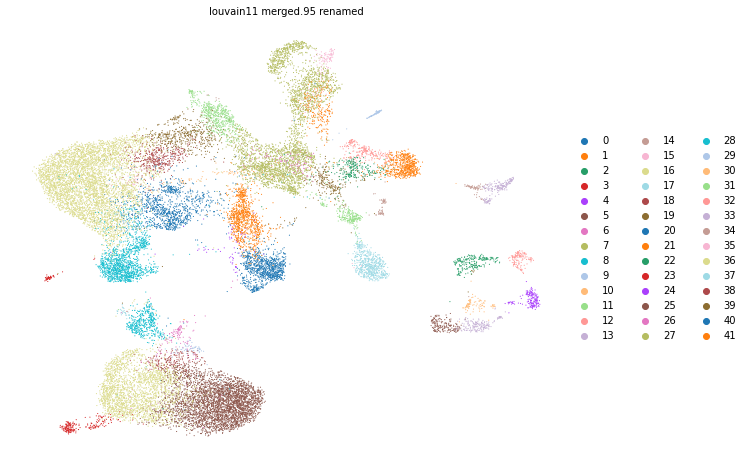

In [39]:
scv.pl.scatter(adata, color='louvain11_merged.95_renamed', figsize =(10,8), colorbar=True, legend_loc='right margin', palette=scanpy.pl.palettes.default_20)

# And the UMAP we showed in the publication?!

In [45]:
adata.obsm['X_umap_publ'] = adata.obs[ ['umap2d_X', 'umap2d_Y']].values

In [46]:
adata.obsm['X_umap_publ']

array([[ 8.043452 , -2.426405 ],
       [17.034279 , -5.618324 ],
       [ 1.9644263, -6.4252515],
       ...,
       [17.491543 , -1.8563019],
       [11.409926 ,  2.8729393],
       [15.764604 , -3.6091306]])

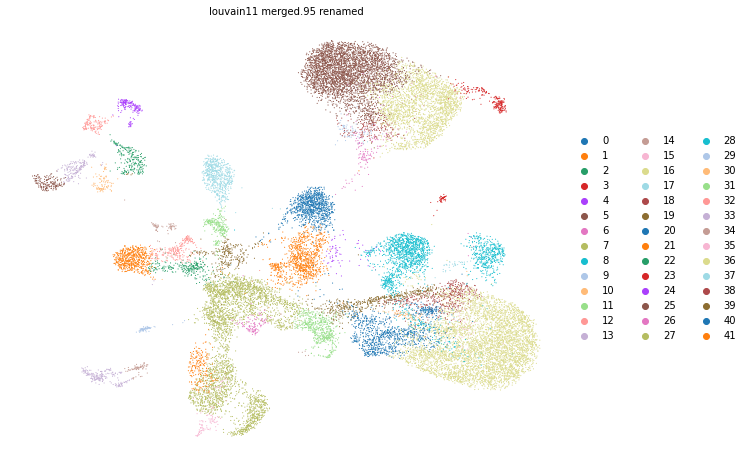

In [47]:
scv.pl.scatter(adata, color='louvain11_merged.95_renamed', basis="umap_publ", figsize =(10,8), colorbar=True, 
               legend_loc='right margin', palette=scanpy.pl.palettes.default_20)